# Advanced Dropout Regularization: Preventing Overfitting in Deep Networks

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from SpiralDataSet import SpiralData  # Using the provided spiral dataset

torch.manual_seed(42)  # For reproducibility

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [19]:
class DropoutNet(nn.Module):
    """Neural network with configurable dropout layers"""
    
    def __init__(self, input_size, hidden_sizes, output_size, dropout_probs=None):
        """
        Args:
            input_size: Number of input features
            hidden_sizes: List of hidden layer sizes
            output_size: Number of output classes
            dropout_probs: List of dropout probabilities for each layer
        """
        super(DropoutNet, self).__init__()
        
        self.num_layers = len(hidden_sizes)
        self.dropout_probs = dropout_probs if dropout_probs else [0.0] * self.num_layers
        
        # Create layers and dropouts
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        
        # Input to first hidden layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.dropouts.append(nn.Dropout(p=self.dropout_probs[0]))
        
        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.dropouts.append(nn.Dropout(p=self.dropout_probs[i] if i < len(self.dropout_probs) else 0.0))
        
        # Output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
    
    def forward(self, x):
        """Forward pass through the network with dropout"""
        activation = x
        
        # Pass through hidden layers with dropout
        for i in range(self.num_layers):
            activation = self.layers[i](activation)
            activation = F.relu(activation)
            activation = self.dropouts[i](activation)  # Apply dropout
        
        # Output layer (no activation for classification logits)
        output = self.output_layer(activation)
        return output

In [20]:
def train_with_dropout_analysis(train_dataset, val_dataset, models_config, epochs=500, batch_size=32):
    """
    Train multiple models with different dropout configurations
    
    Args:
        train_dataset: Training dataset
        val_dataset: Validation dataset
        models_config: List of model configurations (name, architecture, dropout rates)
        epochs: Number of training epochs
        batch_size: Training batch size
    """
    # Create data loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize models, optimizers, and tracking
    models = {}
    optimizers = {}
    loss_history = {}
    accuracy_history = {}
    criterion = nn.CrossEntropyLoss()
    
    print(f"Training {len(models_config)} models with different dropout configurations...")
    
    # Initialize models
    for config in models_config:
        name = config['name']
        model = DropoutNet(config['input_size'], config['hidden_sizes'], 
                          config['output_size'], config['dropout_probs']).to(device)
        
        models[name] = model
        optimizers[name] = torch.optim.Adam(model.parameters(), lr=0.01)
        loss_history[name] = {'train': [], 'val': []}
        accuracy_history[name] = {'train': [], 'val': []}
        
        print(f"Initialized {name}")
    
    # Training loop
    for epoch in range(epochs):
        # Training phase
        for name, model in models.items():
            model.train()  # Set to training mode (enables dropout)
            epoch_train_loss = 0.0
            
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                
                optimizers[name].zero_grad()
                predictions = model(batch_x)
                loss = criterion(predictions, batch_y)
                loss.backward()
                optimizers[name].step()
                
                epoch_train_loss += loss.item()
            
            # Store average training loss
            avg_train_loss = epoch_train_loss / len(train_loader)
            loss_history[name]['train'].append(avg_train_loss)
        
        # Validation phase (every 10 epochs)
        if (epoch + 1) % 10 == 0:
            for name, model in models.items():
                model.eval()  # Set to evaluation mode (disables dropout)
                
                with torch.no_grad():
                    # Training accuracy
                    train_x, train_y = train_dataset.x.to(device), train_dataset.y.to(device)
                    train_pred = model(train_x)
                    train_loss = criterion(train_pred, train_y).item()
                    _, train_predicted = torch.max(train_pred, 1)
                    train_acc = (train_predicted == train_y).float().mean().item()
                    
                    # Validation accuracy
                    val_x, val_y = val_dataset.x.to(device), val_dataset.y.to(device)
                    val_pred = model(val_x)
                    val_loss = criterion(val_pred, val_y).item()
                    _, val_predicted = torch.max(val_pred, 1)
                    val_acc = (val_predicted == val_y).float().mean().item()
                    
                    # Store metrics
                    loss_history[name]['val'].append(val_loss)
                    accuracy_history[name]['train'].append(train_acc)
                    accuracy_history[name]['val'].append(val_acc)
        
        # Progress reporting
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] completed")
    
    print("Training completed for all models!")
    return models, loss_history, accuracy_history

In [21]:
# First, create a nonlinear classification dataset
class NonlinearData(Dataset):
    """Generate nonlinear dataset for dropout experiments"""
    
    def __init__(self, N_SAMPLES=1000, noise_std=0.15, train=True):
        # Define polynomial coefficients 
        a = np.matrix([-1, 1, 2, 1, 1, -3, 1]).T
        
        # Generate random 2D points
        self.x = np.matrix(np.random.rand(N_SAMPLES, 2))
        
        # Create polynomial decision function
        self.f = np.array(a[0] + (self.x) * a[1:3] + 
                         np.multiply(self.x[:, 0], self.x[:, 1]) * a[4] + 
                         np.multiply(self.x, self.x) * a[5:7]).flatten()
        
        self.a = a  
        
        # Create binary labels
        self.y = np.zeros(N_SAMPLES)
        self.y[self.f > 0] = 1
        
        # Convert to PyTorch tensors
        self.y = torch.from_numpy(self.y).type(torch.LongTensor)
        self.x = torch.from_numpy(self.x).type(torch.FloatTensor)
        self.f = torch.from_numpy(self.f)
        
        # Add noise
        if train == True:
            torch.manual_seed(1)
            self.x = self.x + noise_std * torch.randn(self.x.size())
            torch.manual_seed(0)
        else:
            self.x = self.x + noise_std * torch.randn(self.x.size())
        
        self.len = N_SAMPLES
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.len

# Create datasets
print("=== Creating Datasets for Dropout Experiments ===")
train_dataset = NonlinearData(N_SAMPLES=1000, noise_std=0.2, train=True)
val_dataset = NonlinearData(N_SAMPLES=500, noise_std=0.2, train=False)
print(f"Training dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(val_dataset)} samples")

=== Creating Datasets for Dropout Experiments ===
Training dataset: 1000 samples
Validation dataset: 500 samples


In [22]:
# Define model configurations with different dropout rates
models_config = [
    {
        'name': 'No Dropout',
        'input_size': 2,
        'hidden_sizes': [300, 300, 300],
        'output_size': 2,
        'dropout_probs': [0.0, 0.0, 0.0]  # No dropout
    },
    {
        'name': 'Light Dropout (0.2)',
        'input_size': 2,
        'hidden_sizes': [300, 300, 300],
        'output_size': 2,
        'dropout_probs': [0.2, 0.2, 0.2]  # Light dropout
    },
    {
        'name': 'Medium Dropout (0.5)',
        'input_size': 2,
        'hidden_sizes': [300, 300, 300],
        'output_size': 2,
        'dropout_probs': [0.5, 0.5, 0.5]  # Medium dropout
    },
    {
        'name': 'Heavy Dropout (0.7)',
        'input_size': 2,
        'hidden_sizes': [300, 300, 300],
        'output_size': 2,
        'dropout_probs': [0.7, 0.7, 0.7]  # Heavy dropout
    }
]

# Train models with different dropout rates
print("=== Experiment: Dropout Effects on Nonlinear Dataset ===")
models, loss_hist, acc_hist = train_with_dropout_analysis(
    train_dataset, val_dataset, models_config, epochs=500, batch_size=32
)

=== Experiment: Dropout Effects on Nonlinear Dataset ===
Training 4 models with different dropout configurations...
Initialized No Dropout
Initialized Light Dropout (0.2)
Initialized Medium Dropout (0.5)
Initialized Heavy Dropout (0.7)
Epoch [100/500] completed
Epoch [200/500] completed
Epoch [300/500] completed
Epoch [400/500] completed
Epoch [500/500] completed
Training completed for all models!



Generating dropout comparison plots...


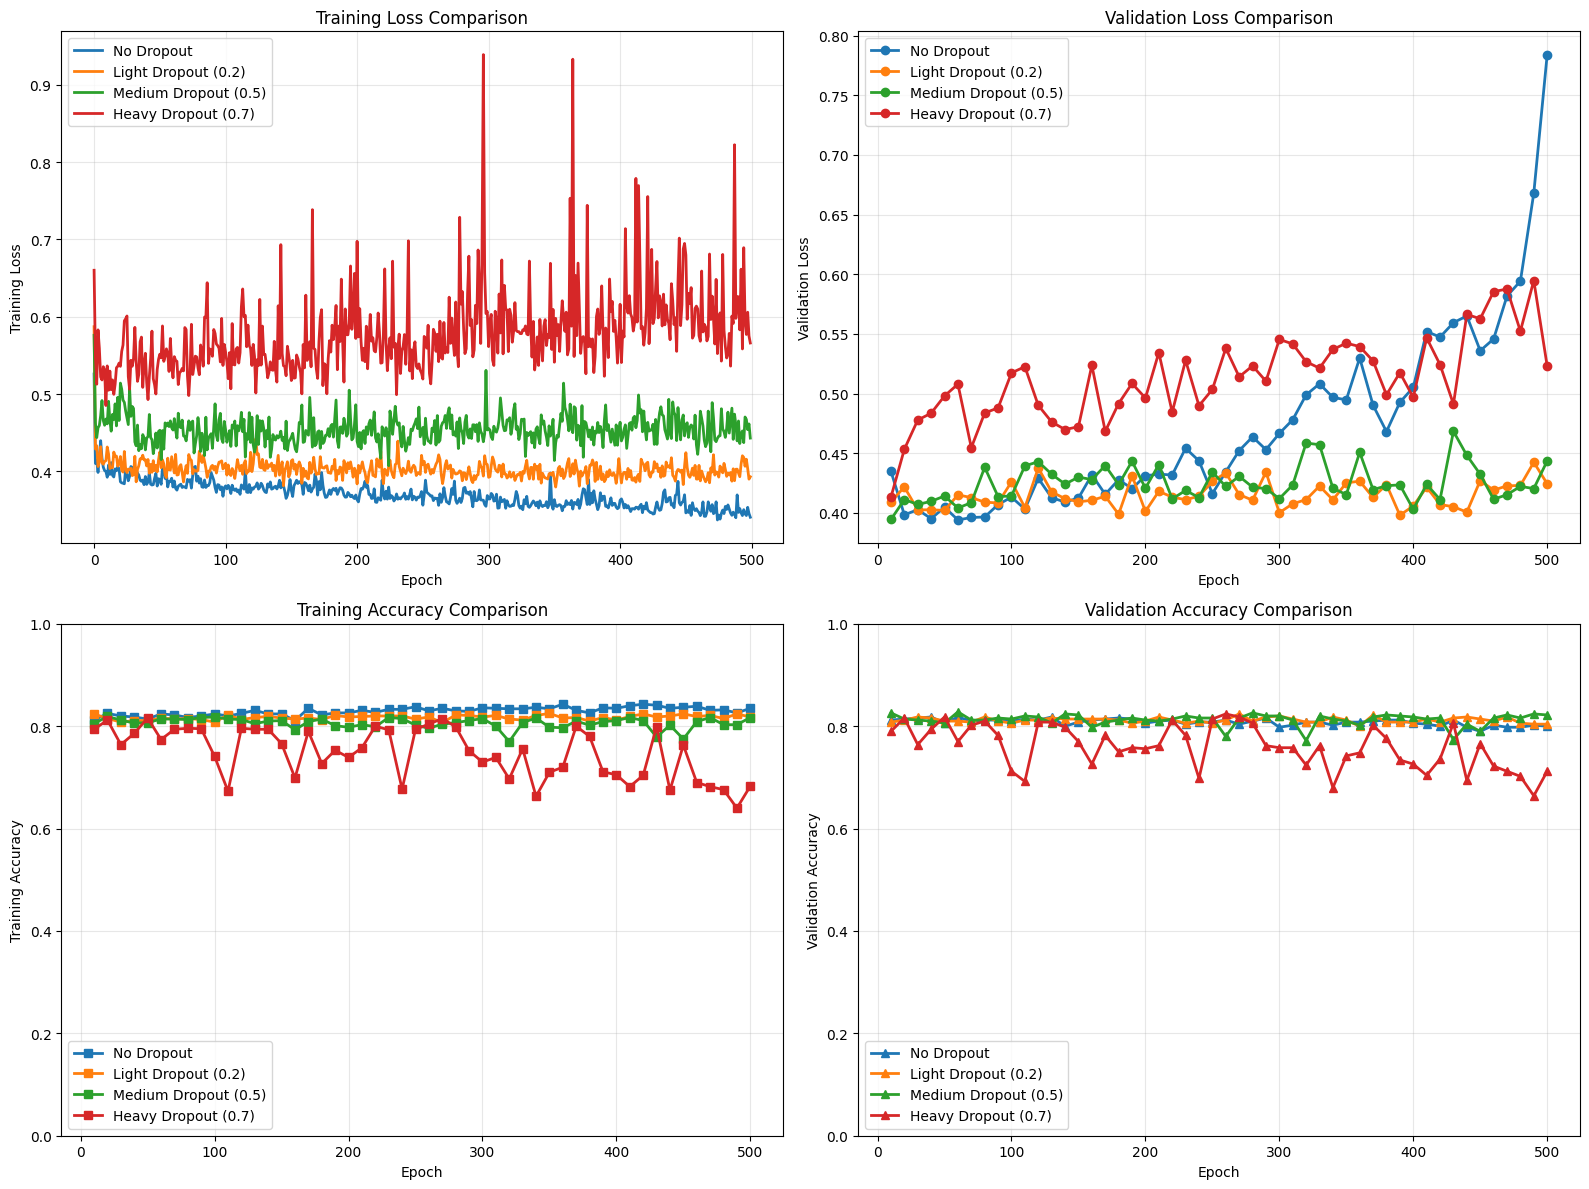

In [23]:
def plot_dropout_comparison(loss_history, accuracy_history):
    """Plot comprehensive comparison of models with different dropout rates"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Training Loss
    ax1 = axes[0, 0]
    for name, losses in loss_history.items():
        ax1.plot(losses['train'], label=name, linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss')
    ax1.set_title('Training Loss Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Validation Loss
    ax2 = axes[0, 1]
    for name, losses in loss_history.items():
        epochs_val = range(10, len(losses['train']) + 1, 10)
        ax2.plot(epochs_val, losses['val'], label=name, linewidth=2, marker='o')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Validation Loss')
    ax2.set_title('Validation Loss Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Training Accuracy
    ax3 = axes[1, 0]
    for name, accuracies in accuracy_history.items():
        epochs_acc = range(10, len(accuracies['train']) * 10 + 1, 10)
        ax3.plot(epochs_acc, accuracies['train'], label=name, linewidth=2, marker='s')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Training Accuracy')
    ax3.set_title('Training Accuracy Comparison')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1)
    
    # Plot 4: Validation Accuracy
    ax4 = axes[1, 1]
    for name, accuracies in accuracy_history.items():
        epochs_acc = range(10, len(accuracies['val']) * 10 + 1, 10)
        ax4.plot(epochs_acc, accuracies['val'], label=name, linewidth=2, marker='^')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Validation Accuracy')
    ax4.set_title('Validation Accuracy Comparison')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

# Generate visualization
print("\nGenerating dropout comparison plots...")
plot_dropout_comparison(loss_hist, acc_hist)

In [24]:
def analyze_dropout_effectiveness(models, accuracy_history):
    """Analyze and summarize dropout effectiveness"""
    
    print(f"\n=== Dropout Effectiveness Analysis ===")
    
    # Extract final metrics
    final_results = {}
    for name in models.keys():
        final_train_acc = accuracy_history[name]['train'][-1]
        final_val_acc = accuracy_history[name]['val'][-1]
        overfitting_gap = final_train_acc - final_val_acc
        
        final_results[name] = {
            'train_acc': final_train_acc,
            'val_acc': final_val_acc,
            'overfitting_gap': overfitting_gap,
            'best_val_acc': max(accuracy_history[name]['val'])
        }
    
    # Display results table
    print(f"{'Model':<20} {'Train Acc':<12} {'Val Acc':<12} {'Gap':<12} {'Best Val':<12}")
    print(f"{'-'*20} {'-'*12} {'-'*12} {'-'*12} {'-'*12}")
    
    for name, results in final_results.items():
        print(f"{name:<20} {results['train_acc']:<12.4f} {results['val_acc']:<12.4f} "
              f"{results['overfitting_gap']:<12.4f} {results['best_val_acc']:<12.4f}")
    
    # Find best models
    best_generalization = min(final_results, key=lambda x: final_results[x]['overfitting_gap'])
    best_validation = max(final_results, key=lambda x: final_results[x]['best_val_acc'])
    
    print(f"\nKey Insights:")
    print(f"• Best Generalization (lowest gap): {best_generalization}")
    print(f"• Best Validation Performance: {best_validation}")
    
    return final_results

# Analyze results
results = analyze_dropout_effectiveness(models, acc_hist)


=== Dropout Effectiveness Analysis ===
Model                Train Acc    Val Acc      Gap          Best Val    
-------------------- ------------ ------------ ------------ ------------
No Dropout           0.8350       0.8000       0.0350       0.8180      
Light Dropout (0.2)  0.8180       0.8040       0.0140       0.8240      
Medium Dropout (0.5) 0.8170       0.8220       -0.0050      0.8280      
Heavy Dropout (0.7)  0.6830       0.7120       -0.0290      0.8240      

Key Insights:
• Best Generalization (lowest gap): Heavy Dropout (0.7)
• Best Validation Performance: Medium Dropout (0.5)


In [25]:
print(f"\n=== Dropout Insights and Best Practices ===")

print(f"\nDropout Mechanisms:")
print(f"• During Training: Randomly sets neurons to 0 with probability p")
print(f"• During Inference: All neurons active, outputs scaled by (1-p)")
print(f"• Forces network to learn redundant representations")
print(f"• Prevents co-adaptation of neurons")

print(f"\nOptimal Dropout Rates:")
print(f"• Input layers: 0.1 - 0.2 (light dropout)")
print(f"• Hidden layers: 0.3 - 0.5 (moderate dropout)")
print(f"• Deep networks: Higher dropout rates (0.4 - 0.6)")

print(f"\nBest Practices for Dropout:")
print(f"• Start with moderate rates (0.3-0.5) and tune based on validation")
print(f"• Use higher rates for larger networks")
print(f"• Apply different rates to different layers")
print(f"• Monitor training vs validation performance")
print(f"• Combine with other regularization like weight decay")

print(f"\nConclusion:")
print(f"• Dropout is essential for preventing overfitting in deep networks")
print(f"• Proper dropout leads to better generalization and robustness")
print(f"• The optimal dropout rate depends on network architecture and dataset complexity")


=== Dropout Insights and Best Practices ===

Dropout Mechanisms:
• During Training: Randomly sets neurons to 0 with probability p
• During Inference: All neurons active, outputs scaled by (1-p)
• Forces network to learn redundant representations
• Prevents co-adaptation of neurons

Optimal Dropout Rates:
• Input layers: 0.1 - 0.2 (light dropout)
• Hidden layers: 0.3 - 0.5 (moderate dropout)
• Deep networks: Higher dropout rates (0.4 - 0.6)

Best Practices for Dropout:
• Start with moderate rates (0.3-0.5) and tune based on validation
• Use higher rates for larger networks
• Apply different rates to different layers
• Monitor training vs validation performance
• Combine with other regularization like weight decay

Conclusion:
• Dropout is essential for preventing overfitting in deep networks
• Proper dropout leads to better generalization and robustness
• The optimal dropout rate depends on network architecture and dataset complexity
